In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/alex/.local/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [3]:
# input
C = 8
L = 2

custom_setup = True
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
# define the locations of customers and lockers
C_location = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
                       [0.9 ,0.5],[0.7 ,0.3], [0.4, 0.15]])
W_location = np.array([[0.6 ,0.5]])
L_location = np.array([[0.3 ,0.5],[0.5,0.2]])

In [5]:
# Customers’ demand and preferences
q = np.ones(C)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in C:
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores)) # TODO assign not a random store but the one that in most case is the nearest to the customer
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)


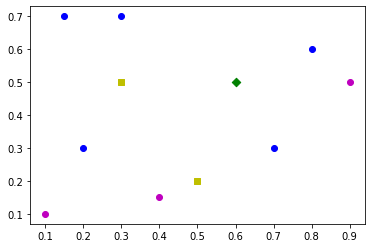

In [6]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])
for i in range(C):
    if i in S_k:
        S_k_location=np.vstack([S_k_location,C_location[i]])

S_k_location=np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))


#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker


plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [7]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

            W        L0        L1       Cd0       Cd1       Cd2       Cd3  \
W    0.000000  0.300000  0.316228  0.447214  0.492443  0.360555  0.223607   
L0   0.300000  0.000000  0.360555  0.223607  0.250000  0.200000  0.509902   
L1   0.316228  0.360555  0.000000  0.316228  0.610328  0.538516  0.500000   
Cd0  0.447214  0.223607  0.316228  0.000000  0.403113  0.412311  0.670820   
Cd1  0.492443  0.250000  0.610328  0.403113  0.000000  0.150000  0.657647   
Cd2  0.360555  0.200000  0.538516  0.412311  0.150000  0.000000  0.509902   
Cd3  0.223607  0.509902  0.500000  0.670820  0.657647  0.509902  0.000000   
Cd4  0.223607  0.447214  0.223607  0.500000  0.680074  0.565685  0.316228   
Cl0  0.640312  0.447214  0.412311  0.223607  0.602080  0.632456  0.860233   
Cl1  0.300000  0.600000  0.500000  0.728011  0.776209  0.632456  0.141421   
Cl2  0.403113  0.364005  0.111803  0.250000  0.604152  0.559017  0.602080   

          Cd4       Cl0       Cl1       Cl2  
W    0.223607  0.640312  0.30

In [8]:
#filtro i dati

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

           W        L0        L1
W   0.000000  0.300000  0.316228
L0  0.300000  0.000000  0.360555
L1  0.316228  0.360555  0.000000
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.447214  0.492443  0.360555  0.223607  0.223607
Cd0  0.447214  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.492443  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.360555  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.223607  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.223607  0.500000  0.680074  0.565685  0.316228  0.000000
          Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.223607  0.250000  0.200000  0.509902  0.447214
L1   0.316228  0.610328  0.538516  0.500000  0.223607
Cd0  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.500000  0.680074  0.565685  0.31622

In [9]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

           W        L0        L1
W   0.000000  0.225000  0.237171
L0  0.225000  0.000000  0.270416
L1  0.237171  0.270416  0.000000
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.447214  0.492443  0.360555  0.223607  0.223607
Cd0  0.447214  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.492443  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.360555  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.223607  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.223607  0.500000  0.680074  0.565685  0.316228  0.000000
          Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.190066  0.212500  0.170000  0.433417  0.380132
L1   0.268794  0.518779  0.457739  0.425000  0.190066
Cd0  0.000000  0.342646  0.350464  0.570197  0.425000
Cd1  0.342646  0.000000  0.127500  0.559000  0.578062
Cd2  0.350464  0.127500  0.000000  0.433417  0.480833
Cd3  0.570197  0.559000  0.433417  0.000000  0.268794
Cd4  0.425000  0.578062  0.480833  0.26879

In [98]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


comp = dist_matrix.filter(items=Customers_locker,axis=1)
comp = comp.filter(items=stores,axis=0)
print(comp)


min_of_each_column_index = comp.idxmin()
print(min_of_each_column_index)

index_close_locker = []
for i in range(len(min_of_each_column_index)):
    index_close_locker.append(min_of_each_column_index[i])
print(index_close_locker)


d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
print(compensation_matrix_cost.values[1][0])


            W        L0        L1       Sk0       Sk1       Sk2
W    0.000000  0.300000  0.316228  0.447214  0.492443  0.223607
L0   0.300000  0.000000  0.360555  0.223607  0.250000  0.447214
L1   0.316228  0.360555  0.000000  0.316228  0.610328  0.223607
Sk0  0.447214  0.223607  0.316228  0.000000  0.403113  0.500000
Sk1  0.492443  0.250000  0.610328  0.403113  0.000000  0.680074
Sk2  0.223607  0.447214  0.223607  0.500000  0.680074  0.000000
         Cl0  Cl1       Cl2
W   0.640312  0.3  0.403113
L0  0.447214  0.6  0.364005
L1  0.412311  0.5  0.111803
Cl0    L1
Cl1     W
Cl2    L1
dtype: object
['L1', 'W', 'L1']
         Sk0       Sk1       Sk2
L1  0.316228  0.610328  0.223607
W   0.447214  0.492443  0.223607
L1  0.316228  0.610328  0.223607
         Sk0       Sk1       Sk2
L1  0.158114  0.305164  0.111803
W   0.223607  0.246221  0.111803
L1  0.158114  0.305164  0.111803
0.22360679774997896


In [101]:
LF_distances_matrix_collection= {}
for i in range(L):
    l = [0]
    l[0]=lockers[i]
    local_matrix = dist_matrix.filter(items=l+Customers_door,axis=1)
    local_matrix = local_matrix.filter(items=l+Customers_door,axis=0)
    LF_distances_matrix_collection[i]=pd.DataFrame(local_matrix)

for key in LF_distances_matrix_collection.keys():
    print("\n" +"="*65)
    print(key)
    print("-"*65)
    print(LF_distances_matrix_collection[key])




0
-----------------------------------------------------------------
           L0       Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.000000  0.223607  0.250000  0.200000  0.509902  0.447214
Cd0  0.223607  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.250000  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.200000  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.509902  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.447214  0.500000  0.680074  0.565685  0.316228  0.000000

1
-----------------------------------------------------------------
           L1       Cd0       Cd1       Cd2       Cd3       Cd4
L1   0.000000  0.316228  0.610328  0.538516  0.500000  0.223607
Cd0  0.316228  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.610328  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.538516  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.500000  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.223607  0.500000  0.680

In [89]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


comp = dist_matrix.filter(items=Customers_locker,axis=1)
comp = comp.filter(items=stores,axis=0)
print(comp)

index_close_locker = ['']

d_ak_c = {}
for i in range(len(comp)):
    closest_locker =comp[Customers_locker[i]].idxmin()
    index_close_locker[0] = closest_locker
    local_comp_matrix = compensation_matrix.filter(items = S_k_indexes,axis=1)
    local_comp_matrix=local_comp_matrix.filter(items=index_close_locker,axis=0)
    d_ak_c[i]=pd.DataFrame(local_comp_matrix)

for key in d_ak_c.keys():
    print("\n" +"="*35)
    print(key)
    print("-"*35)
    print(d_ak_c[key])

ro = 0.5
compensation_matrix_cost = {}

for i in range(len(comp)):
    cost = ro*d_ak_c[i]
    compensation_matrix_cost[i] = pd.DataFrame(cost)
print("----------------------------------------")
for key in compensation_matrix_cost.keys():
    print("\n" +"="*35)
    print(key)
    print("-"*35)
    print(compensation_matrix_cost[key])


            W        L0        L1       Sk0       Sk1       Sk2
W    0.000000  0.300000  0.316228  0.447214  0.492443  0.223607
L0   0.300000  0.000000  0.360555  0.223607  0.250000  0.447214
L1   0.316228  0.360555  0.000000  0.316228  0.610328  0.223607
Sk0  0.447214  0.223607  0.316228  0.000000  0.403113  0.500000
Sk1  0.492443  0.250000  0.610328  0.403113  0.000000  0.680074
Sk2  0.223607  0.447214  0.223607  0.500000  0.680074  0.000000
         Cl0  Cl1       Cl2
W   0.640312  0.3  0.403113
L0  0.447214  0.6  0.364005
L1  0.412311  0.5  0.111803

0
-----------------------------------
         Sk0       Sk1       Sk2
L1  0.316228  0.610328  0.223607

1
-----------------------------------
        Sk0       Sk1       Sk2
W  0.447214  0.492443  0.223607

2
-----------------------------------
         Sk0       Sk1       Sk2
L1  0.316228  0.610328  0.223607
----------------------------------------

0
-----------------------------------
         Sk0       Sk1       Sk2
L1  0.158114  